# 局部加权线性回归

In [5]:
import numpy as np
import matplotlib.pylab as plt
from numpy import *

### 加载数据

In [2]:
def loadDataSet(fileName):                 
    """ 加载数据
        解析以tab键分隔的文件中的浮点数
    Returns：
        dataMat ：  feature 对应的数据集
        labelMat ： feature 对应的分类标签，即类别标签

    """
    # 获取样本特征的总数，不算最后的目标变量 
    numFeat = len(open(fileName).readline().split('\t')) - 1 
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        # 读取每一行
        lineArr =[]
        # 删除一行中以tab分隔的数据前后的空白符号
        curLine = line.strip().split('\t')
        # i 从0到2，不包括2 
        for i in range(numFeat):
            # 将数据添加到lineArr List中，每一行数据测试数据组成一个行向量           
            lineArr.append(float(curLine[i]))
            # 将测试数据的输入数据部分存储到dataMat 的List中
        dataMat.append(lineArr)
        # 将每一行的最后一个数据，即类别，或者叫目标变量存储到labelMat List中
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

In [20]:
xArr, yArr = loadDataSet("8.Regression/data.txt")

In [23]:
xMat = mat(xArr)

In [25]:
m = shape(xMat)[0]
m

200

In [42]:
mat(eye((m)))

matrix([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]])

## 线性回归

In [4]:
def standRegres(xArr,yArr):
    '''
    Description：
        线性回归
    Args:
        xArr ：输入的样本数据，包含每个样本数据的 feature
        yArr ：对应于输入数据的类别标签，也就是每个样本对应的目标变量
    Returns:
        ws：回归系数
    '''

    # mat()函数将xArr，yArr转换为矩阵 mat().T 代表的是对矩阵进行转置操作
    xMat = mat(xArr)
    yMat = mat(yArr).T
    # 矩阵乘法的条件是左矩阵的列数等于右矩阵的行数
    xTx = xMat.T*xMat
    # 因为要用到xTx的逆矩阵，所以事先需要确定计算得到的xTx是否可逆，条件是矩阵的行列式不为0
    # linalg.det() 函数是用来求得矩阵的行列式的，如果矩阵的行列式为0，则这个矩阵是不可逆的，就无法进行接下来的运算                   
    if linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    # 最小二乘法
    # http://www.apache.wiki/pages/viewpage.action?pageId=5505133
    # 书中的公式，求得w的最优解
    ws = xTx.I * (xMat.T*yMat)            
    return ws

## 局部加权线性回归

In [5]:
def lwlr(testPoint,xArr,yArr,k=1.0):
    '''
        Description：
            局部加权线性回归，在待预测点附近的每个点赋予一定的权重，在子集上基于最小均方差来进行普通的回归。
        Args：
            testPoint：样本点
            xArr：样本的特征数据，即 feature
            yArr：每个样本对应的类别标签，即目标变量
            k:关于赋予权重矩阵的核的一个参数，与权重的衰减速率有关
        Returns:
            testPoint * ws：数据点与具有权重的系数相乘得到的预测点
        Notes:
            这其中会用到计算权重的公式，w = e^((x^((i))-x) / -2k^2)
            理解：x为某个预测点，x^((i))为样本点，样本点距离预测点越近，贡献的误差越大（权值越大），越远则贡献的误差越小（权值越小）。
            关于预测点的选取，在我的代码中取的是样本点。其中k是带宽参数，控制w（钟形函数）的宽窄程度，类似于高斯函数的标准差。
            算法思路：假设预测点取样本点中的第i个样本点（共m个样本点），遍历1到m个样本点（含第i个），算出每一个样本点与预测点的距离，
            也就可以计算出每个样本贡献误差的权值，可以看出w是一个有m个元素的向量（写成对角阵形式）。
    '''
    # mat() 函数是将array转换为矩阵的函数， mat().T 是转换为矩阵之后，再进行转置操作
    xMat = mat(xArr)
    yMat = mat(yArr).T
    # 获得xMat矩阵的行数
    m = shape(xMat)[0]
    # eye()返回一个对角线元素为1，其他元素为0的二维数组，创建权重矩阵weights，该矩阵为每个样本点初始化了一个权重                   
    weights = mat(eye((m)))  # 200 x 200
    for j in range(m):
        # testPoint 的形式是 一个行向量的形式
        # 计算 testPoint 与输入样本点之间的距离，然后下面计算出每个样本贡献误差的权值
        # 1x2 - 
        diffMat = testPoint - xMat[j,:]
        # k控制衰减的速度
        weights[j,j] = exp(diffMat*diffMat.T/(-2.0*k**2))
    # 根据矩阵乘法计算 xTx ，其中的 weights 矩阵是样本点对应的权重矩阵
    xTx = xMat.T * (weights * xMat)
    if linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    # 计算出回归系数的一个估计  每次都要不一样
    ws = xTx.I * (xMat.T * (weights * yMat))
    return testPoint * ws


def lwlrTest(testArr,xArr,yArr,k=1.0):
    '''
        Description：
            测试局部加权线性回归，对数据集中每个点调用 lwlr() 函数
        Args：
            testArr：测试所用的所有样本点
            xArr：样本的特征数据，即 feature
            yArr：每个样本对应的类别标签，即目标变量
            k：控制核函数的衰减速率
        Returns：
            yHat：预测点的估计值
    '''
    # 得到样本点的总数
    m = shape(testArr)[0]
    # 构建一个全部都是 0 的 1 * m 的矩阵
    yHat = zeros(m)
    # 循环所有的数据点，并将lwlr运用于所有的数据点 
    for i in range(m):
        yHat[i] = lwlr(testArr[i],xArr,yArr,k)
    # 返回估计值
    return yHat

def lwlrTestPlot(xArr,yArr,k=1.0):  
    '''
        Description:
            首先将 X 排序，其余的都与lwlrTest相同，这样更容易绘图
        Args：
            xArr：样本的特征数据，即 feature
            yArr：每个样本对应的类别标签，即目标变量，实际值
            k：控制核函数的衰减速率的有关参数，这里设定的是常量值 1
        Return：
            yHat：样本点的估计值
            xCopy：xArr的复制
    '''
    # 生成一个与目标变量数目相同的 0 向量
    yHat = zeros(shape(yArr))
    # 将 xArr 转换为 矩阵形式
    xCopy = mat(xArr)
    # 排序
    xCopy.sort(0)
    # 开始循环，为每个样本点进行局部加权线性回归，得到最终的目标变量估计值
    for i in range(shape(xArr)[0]):
        yHat[i] = lwlr(xCopy[i],xArr,yArr,k)
    return yHat,xCopy

In [6]:
#test for LWLR
def regression2(k):
    xArr, yArr = loadDataSet("8.Regression/data.txt")
    yHat = lwlrTest(xArr, xArr, yArr, k)
    xMat = mat(xArr)
    srtInd = xMat[:,1].argsort(0)           #argsort()函数是将x中的元素从小到大排列，提取其对应的index(索引)，然后输出
    xSort=xMat[srtInd][:,0,:]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(xSort[:,1], yHat[srtInd])
    ax.scatter(xMat[:,1].flatten().A[0], mat(yArr).T.flatten().A[0] , s=2, c='red')
    plt.show()

In [4]:
xArr, yArr = loadDataSet("8.Regression/data.txt")

In [16]:
len(xArr)

200

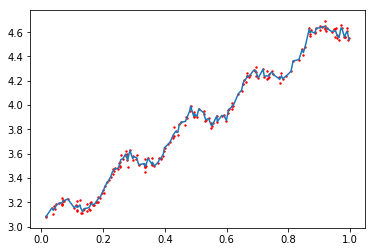

In [39]:
regression2(0.003)

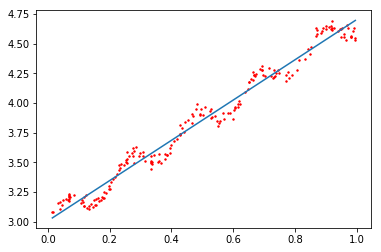

In [40]:
regression2(1.0)

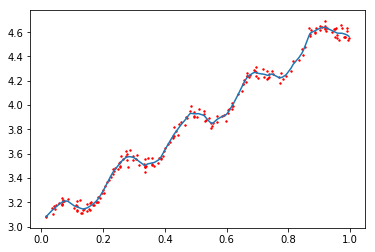

In [41]:
regression2(0.01)

<br><br><br>

# 使用局部线性回归预测鲍鱼年龄

In [20]:
def rssError(yArr, yHatArr):
    '''
        Desc:
            计算分析预测误差的大小
        Args:
            yArr：真实的目标变量
            yHatArr：预测得到的估计值
        Returns:
            计算真实值和估计值得到的值的平方和作为最后的返回值
    '''
    return ((yArr - yHatArr) ** 2).sum()

In [21]:
# test for abloneDataSet
def abaloneTest():
    '''
    Desc:
        预测鲍鱼的年龄
    Args:
        None
    Returns:
        None
    '''
    # 加载数据
    abX, abY = loadDataSet("8.Regression/abalone.txt")
    # 使用不同的核进行预测
    oldyHat01 = lwlrTest(abX[0:99], abX[0:99], abY[0:99], 0.1)
    oldyHat1 = lwlrTest(abX[0:99], abX[0:99], abY[0:99], 1)
    oldyHat10 = lwlrTest(abX[0:99], abX[0:99], abY[0:99], 10)   
    # 打印出不同的核预测值与训练数据集上的真实值之间的误差大小
    print("old yHat01 error Size is :" , rssError(abY[0:99], oldyHat01.T))
    print("old yHat1 error Size is :" , rssError(abY[0:99], oldyHat1.T))
    print("old yHat10 error Size is :" , rssError(abY[0:99], oldyHat10.T))

    # 打印出 不同的核预测值 与 新数据集（测试数据集）上的真实值之间的误差大小
    newyHat01 = lwlrTest(abX[100:199], abX[0:99], abY[0:99], 0.1)
    print("new yHat01 error Size is :" , rssError(abY[0:99], newyHat01.T))
    newyHat1 = lwlrTest(abX[100:199], abX[0:99], abY[0:99], 1)
    print("new yHat1 error Size is :" , rssError(abY[0:99], newyHat1.T))
    newyHat10 = lwlrTest(abX[100:199], abX[0:99], abY[0:99], 10)
    print("new yHat10 error Size is :" , rssError(abY[0:99], newyHat10.T))

    # 使用简单的 线性回归 进行预测，与上面的计算进行比较
    standWs = standRegres(abX[0:99], abY[0:99])
    standyHat = mat(abX[100:199]) * standWs
    print("standRegress error Size is:", rssError(abY[100:199], standyHat.T.A))

In [22]:
abaloneTest()

old yHat01 error Size is : 56.78868743048742
old yHat1 error Size is : 429.8905618704059
old yHat10 error Size is : 549.1181708828803
new yHat01 error Size is : 62452.59620515082
new yHat1 error Size is : 3207.6896288234425
new yHat10 error Size is : 3320.089210907004
standRegress error Size is: 518.6363153245542


In [18]:
print("standRegress error Size is:", abX[1], 11)

standRegress error Size is:%s, %s [1.0, 0.35, 0.265, 0.09, 0.2255, 0.0995, 0.0485, 0.07] 11
